In [1]:
# api
import json
import requests

# sunrise and sunset
import datetime
from astral.sun import sun
from astral import LocationInfo

# long and lat
from geopy.geocoders import Nominatim

# utils
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# prefs
plt.style.use('fivethirtyeight')
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)

In [2]:
# api
api_get = 'C03002_003E,C03002_004E,C03002_005E,C03002_006E,C03002_007E,C03002_008E,C03002_009E,C03002_012E'
api_for = 'county:*'
api_key = '4663cae62a3c2ac1881d294a5cc286c501196ef0'

# construct the api call we will use
api_url = f'https://api.census.gov/data/2017/acs/acs1?get={api_get}&for={api_for}&key={api_key}'

# call the api and collect the response
response = requests.get(api_url)

cols = ['White',
        'Black',
        'Indigenous',
        'Asian',
        'Pacific_Islander',
        'Other',
        'Mixed',
        'Hispanic',
        'State',
        'County']

# philidelphia city and county are coextensive
census = pd.DataFrame(json.loads(response.text)[1:], columns=cols)
philly = census[(census.State=='42')&(census.County=='101')].astype('int').reset_index(drop=True)

# merge cols
philly.Other += philly.Indigenous + philly.Mixed
philly.Asian += philly.Pacific_Islander
philly = philly.drop(columns=['Indigenous', 'Pacific_Islander', 'Mixed', 'State', 'County'])
philly_normed = round(philly/philly.iloc[0].sum(), 3)

# display pop. by race
print(f"{philly.columns[0]}\t{philly.columns[1]}\t{philly.columns[2]}\t{philly.columns[3]}\t{philly.columns[4]}")
print(f"{philly.values[0][0]}\t{philly.values[0][1]}\t{philly.values[0][2]}\t{philly.values[0][3]}\t{philly.values[0][4]}")
print(f"{philly_normed.values[0][0]}\t{philly_normed.values[0][1]}\t{philly_normed.values[0][2]}\t{philly_normed.values[0][3]}\t{philly_normed.values[0][4]}")
# print(pd.concat([philly, philly_normed]).reset_index().T.rename(columns={0:'Total Pop.', 1:'Percentage'}).T.drop(columns=['index'])) #<-- alt. way to display pop. table

White	Black	Asian	Other	Hispanic
545580	647102	115008	38990	234183
0.345	0.409	0.073	0.025	0.148


In [3]:
# philadelphia lat and long centroid
address='Philadelphia'
geopy_user_agent = 'Elliot_'
geolocator = Nominatim(user_agent=geopy_user_agent)
location = geolocator.geocode(address)
print((location.latitude, location.longitude))

(39.9527237, -75.1635262)


In [4]:
# read in police stops dataset
stops = pd.read_csv('data/pa_philadelphia_2020_04_01.csv')

display(stops.head(3))
stops.info()

/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,raw_row_number,date,time,location,lat,lng,district,service_area,subject_age,subject_race,subject_sex,type,arrest_made,outcome,contraband_found,frisk_performed,search_conducted,search_person,search_vehicle,raw_race,raw_individual_contraband,raw_vehicle_contraband
0,411981,2014-01-01,01:14:00,NaN,NaN,NaN,19.0,191,31.0,black,male,pedestrian,True,arrest,True,False,True,True,False,Black - Non-Latino,True,False
1,407442,2014-01-01,01:57:00,NaN,NaN,NaN,12.0,121,21.0,black,male,pedestrian,True,arrest,False,True,True,True,False,Black - Non-Latino,False,False
2,217556,2014-01-01,03:30:00,3400 BLOCK SPRUCE ST,39.950424,-75.19268,18.0,183,24.0,black,male,pedestrian,False,NaN,NaN,False,False,False,False,Black - Non-Latino,False,False


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1865096 entries, 0 to 1865095
Data columns (total 22 columns):
raw_row_number               object
date                         object
time                         object
location                     object
lat                          float64
lng                          float64
district                     float64
service_area                 object
subject_age                  float64
subject_race                 object
subject_sex                  object
type                         object
arrest_made                  bool
outcome                      object
contraband_found             object
frisk_performed              bool
search_conducted             bool
search_person                bool
search_vehicle               bool
raw_race                     object
raw_individual_contraband    bool
raw_vehicle_contraband       bool
dtypes: bool(7), float64(4), object(11)
memory usage: 225.9+ MB


In [5]:
# merge other and unknown subject race
stops.subject_race = np.where((stops.subject_race == 'other') | (stops.subject_race == 'unknown'),
                              'other/unknown',
                              stops.subject_race)

# rename columns to match census format
conds = [stops.subject_race == 'white',
         stops.subject_race == 'black',
         stops.subject_race == 'asian/pacific islander',
         stops.subject_race == 'hispanic',
         stops.subject_race == 'other/unknown']

stops.subject_race = np.select(conds, ['White',
                                       'Black',
                                       'Asian',
                                       'Hispanic',
                                       'Other'])

In [6]:
# convert 'date' to date_time obj
stops.date = pd.to_datetime(stops.date)

# display range of dates (start to end)
print(min(stops.date).date())
print(max(stops.date).date())
# stops.date.agg(['min', 'max']) #<-- alt. way to display date range

2014-01-01
2018-04-14


In [7]:
# drop 2018 (partial year)
stops = stops[stops.date < '2018-01-01']

# display new end date and new number of stops
print(max(stops.date).date())
display(len(stops))

2017-12-31


1756587

In [8]:
# display types of stops
print(stops.type.value_counts())

vehicular     1080575
pedestrian    676012 
Name: type, dtype: int64


In [9]:
# drop pedestrian stops
stops = stops[stops.type == 'vehicular']

# check types of stops and display new number of stops
print(stops.type.value_counts())
display(len(stops))

vehicular    1080575
Name: type, dtype: int64


1080575

In [10]:
# display stops by year
display("Stops/Year",
        "n",
        stops.date.map(lambda x: x.year).value_counts(),
        "prop",
        stops.date.map(lambda x: x.year).value_counts(normalize=True))

# display stops by race
display("Stops/Race",
        "n",
        stops.subject_race.value_counts(),
        "prop",
        stops.subject_race.value_counts(normalize=True))

'Stops/Year'

'n'

2017    294060
2016    285755
2015    283537
2014    217223
Name: date, dtype: int64

'prop'

2017    0.272133
2016    0.264447
2015    0.262395
2014    0.201025
Name: date, dtype: float64

'Stops/Race'

'n'

Black       706853
White       215314
Hispanic    112315
Asian       31048 
Other       15045 
Name: subject_race, dtype: int64

'prop'

Black       0.654145
White       0.199259
Hispanic    0.103940
Asian       0.028733
Other       0.013923
Name: subject_race, dtype: float64

How to explain racial disparity?

In [11]:
# check stops per year per race
stops.groupby([stops.date.map(lambda x: x.year), stops.subject_race]).size()

date  subject_race
2014  Asian           7265  
      Black           132871
      Hispanic        22904 
      Other           2620  
      White           51563 
2015  Asian           8580  
      Black           181193
      Hispanic        29935 
      Other           3778  
      White           60051 
2016  Asian           7741  
      Black           190973
      Hispanic        29673 
      Other           4137  
      White           53231 
2017  Asian           7462  
      Black           201816
      Hispanic        29803 
      Other           4510  
      White           50469 
dtype: int64

This table has too many entries to digest quickly. Visualizing the stops per year per race will be more effective.

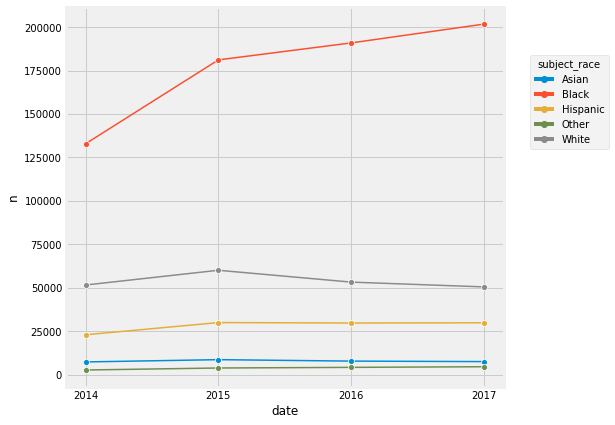

In [12]:
# visualize trend
fig = plt.figure(figsize=(7,7))
ax = plt.axes()
sns.lineplot(data=stops.groupby([stops.date.map(lambda x: x.year),
                                 stops.subject_race]).size().unstack(level=1),
             dashes=False,
             markers=["o"]*5,
             linewidth=1.5)
# plt.setp(ax.lines, linewidth=2)
ax.set_xticks([2014, 2015, 2016, 2017])
ax.set_ylabel('n', )
plt.legend(loc='center right', title='subject_race', bbox_to_anchor=(1.25, .75))
plt.show()

Black subject stops continue increasing past 2015 while other races plateau. Data should be analyzed annualy. This trend dissapears if pedestrian stops included

...

looking at trends by sub-categories can often be very helpful. (E.g., in Nashville, looking at the different listed stop reasons uncovers the extent of the disparities.)

Examine year 2017 -- Benchmark tests: establish baseline (are blacks stopped more because they make up more of the population?)

In [13]:
# get stops for year 2017 only
stops_2017 = stops[stops.date.map(lambda x: x.year) == 2017]

# get stops per race for year 2017 only
race_2017 = pd.concat([stops_2017.groupby(stops.subject_race).size(),
                philly.T], axis=1, sort=True)
race_2017.columns = ['n', 'num_people']

# get 2017 stop rate
race_2017['stop_rate'] = race_2017.n / race_2017.num_people

display(race_2017)

,n,num_people,stop_rate
Asian,7462,115008,0.064882
Black,201816,647102,0.311877
Hispanic,29803,234183,0.127264
Other,4510,38990,0.115671
White,50469,545580,0.092505


In [14]:
# black and white stop rates
display(race_2017.stop_rate['Black'] / race_2017.stop_rate['White'])

# black and hispanic stop rates
display(race_2017.stop_rate['Hispanic'] / race_2017.stop_rate['White'])

3.371448995646344

1.3757463187611347

In [15]:
# check frisk/search values
display(stops_2017.search_conducted.value_counts())
display(stops_2017.frisk_performed.value_counts())

False    278193
True     15867 
Name: search_conducted, dtype: int64

False    278297
True     15763 
Name: frisk_performed, dtype: int64

In [16]:
# get search and frisk rates per race
search_frisk = pd.concat([stops_2017.groupby('subject_race').search_conducted.mean(),
                          stops_2017.groupby('subject_race').frisk_performed.mean()], axis=1)
search_frisk.columns = ['search_rate', 'frisk_rate']

display(search_frisk)

,search_rate,frisk_rate
subject_race,,
Asian,0.026132,0.018494
Black,0.059207,0.062235
Hispanic,0.050532,0.046606
Other,0.036807,0.033481
White,0.040639,0.030217


In [17]:
# black and white search rates
display(search_frisk.search_rate['Black'] / search_frisk.search_rate['White'])

# black and white frisk rates
display(search_frisk.frisk_rate['Black'] / search_frisk.frisk_rate['White'])

# hispanic and white stfriskop rates
display(search_frisk.search_rate['Hispanic'] / search_frisk.search_rate['White'])

# hispanic and white frisk rates
display(search_frisk.frisk_rate['Hispanic'] / search_frisk.frisk_rate['White'])

1.4569176552669678

2.0596285400692858

1.243437693314982

1.5424003634797465

Problems with out benchmark test:

1. Our census pop. data doesn't capture what the distribution of driving behavior looks like (Philly residents != Philly drivers)

2. Rates of justifiable searches might also vary by race, so we need to check outcomes of searches (hit_rate)

In [18]:
stops_2017.contraband_found.value_counts()

False    12300
True     3567 
Name: contraband_found, dtype: int64

In [19]:
stops.isna().sum()

raw_row_number               0      
date                         0      
time                         0      
location                     19995  
lat                          58684  
lng                          58684  
district                     0      
service_area                 1      
subject_age                  2209   
subject_race                 0      
subject_sex                  227    
type                         0      
arrest_made                  0      
outcome                      1057260
contraband_found             1035975
frisk_performed              0      
search_conducted             0      
search_person                0      
search_vehicle               0      
raw_race                     0      
raw_individual_contraband    0      
raw_vehicle_contraband       0      
dtype: int64

In [20]:
stops[stops.search_conducted==True].groupby(['subject_race', 'contraband_found']).size()

subject_race  contraband_found
Asian         False               441  
              True                132  
Black         False               22619
              True                8411 
Hispanic      False               3609 
              True                1342 
Other         False               346  
              True                84   
White         False               5301 
              True                2315 
dtype: int64

In [21]:
searches_2017 = stops_2017[stops_2017.search_conducted==True]
searches_2017.contraband_found = searches_2017.contraband_found.astype(bool)
dff = pd.DataFrame(searches_2017.groupby('subject_race').contraband_found.mean()).rename(columns={'contraband_found':'hit_rate'})
display(dff)

/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,hit_rate
subject_race,
Asian,0.246154
Black,0.223701
Hispanic,0.201859
Other,0.174699
White,0.250122


Are officers searching non-white drivers based on less evidence? Do hit rates vary by precint?

In [22]:
# examine hit rate by district
pd.DataFrame(searches_2017.groupby([searches_2017.subject_race, searches_2017.district]).contraband_found.mean()).rename(columns={'contraband_found':'hit_rate'})

hit_rate
subject_race district          
Asian        1.0       0.166667
             2.0       0.500000
             3.0       0.400000
             6.0       0.333333
             7.0       0.000000
...                         ...
White        25.0      0.282230
             26.0      0.192771
             35.0      0.264151
             39.0      0.580645
             77.0      0.000000

[104 rows x 1 columns]

In [23]:
pd.Index(list(range(1, 23))*2)

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,
            13, 14, 15, 16, 17, 18, 19, 20, 21, 22],
           dtype='int64')

In [24]:
ddff = pd.DataFrame(searches_2017.groupby([searches_2017.subject_race, searches_2017.district]).contraband_found.mean()).rename(columns={'contraband_found':'hit_rate'}).unstack().T.melt(id_vars='White')
ddff = ddff[ddff.subject_race.isin(['Black', 'Hispanic'])]
ddff.fillna(0)
ddff = ddff.set_index(pd.Index(np.tile(stops.district.unique(), 2)))
ddff = ddff.rename(columns={'White':'white_hit_rate', 'value':'minority_hit_rate'})
ddff.sort_index()

,white_hit_rate,subject_race,minority_hit_rate
1.0,0.183333,Hispanic,0.272727
1.0,0.183333,Black,0.263158
2.0,0.241379,Hispanic,0.035714
2.0,0.241379,Black,0.194847
3.0,0.264151,Hispanic,0.174419
3.0,0.264151,Black,0.197346
5.0,0.192771,Hispanic,0.136364
5.0,0.192771,Black,0.283019
6.0,0.580645,Hispanic,0.105263
6.0,0.580645,Black,0.280788


Exclude district 77 (airport, da offices, etc.)

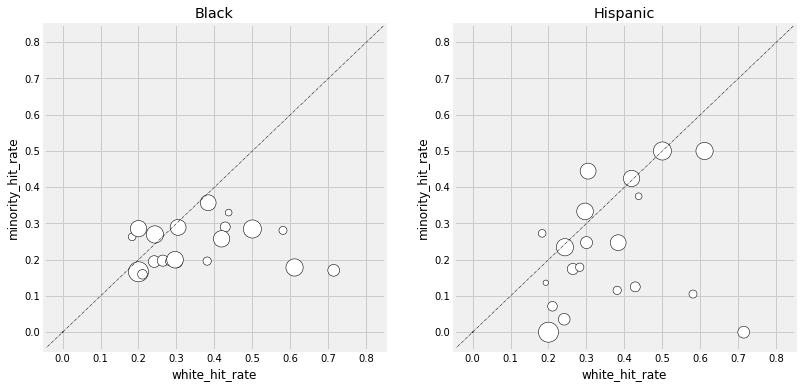

In [25]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
sns.scatterplot(x='white_hit_rate',
                y='minority_hit_rate',
                size=stops_2017.groupby('district').size(),
                data=ddff[ddff.subject_race=='Black'],
                edgecolor='black',
                color="white",
                sizes=(1, 400),                ax=ax[0]).set_title('Black')
ax[0].plot([-0.05, .85], [-0.05, .85], linewidth=0.5, linestyle='-.', color='k')

sns.scatterplot(x='white_hit_rate',
                y='minority_hit_rate',
                size=stops_2017.groupby('district').size(),
                data=ddff[ddff.subject_race=='Hispanic'],
                edgecolor='black',
                color="white",
                sizes=(1, 400),
                ax=ax[1]).set_title('Hispanic')
ax[1].plot([-0.05, .85], [-0.05, .85], linewidth=0.5, linestyle='-.', color='k')
plt.setp(ax, xlim=(-0.05, .85), ylim=(-0.05, .85))
ax[0].get_legend().remove()
ax[1].get_legend().remove()
plt.show()

In [26]:
stops_2017[stops_2017.district == 77].location.value_counts()

0 BLOCK PIA WAY                    245
8800 BLOCK ESSINGTON AVE IA WAY    212
8800 BLOCK ESSINGTON AVE           150
98 PIA WAY                         84 
1 PIA WAY                          44 
                                   .. 
D                                  1  
PIA Fence Line                     1  
PIA S COMMERCIAL RD                1  
SOUTH COMM RD                      1  
B ARRIVALS                         1  
Name: location, Length: 83, dtype: int64

In [27]:
# compute citywide hit rates again with district 77 removed
searches_2017 = stops_2017[(stops_2017.search_conducted==True) & (stops_2017.district!=77)]
searches_2017.contraband_found = searches_2017.contraband_found.astype(bool)
dff = pd.DataFrame(searches_2017.groupby('subject_race').contraband_found.mean()).rename(columns={'contraband_found':'hit_rate'})
display(dff)

/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,hit_rate
subject_race,
Asian,0.309677
Black,0.227761
Hispanic,0.207084
Other,0.198630
White,0.312044


Veil of Darkness Test

In [28]:
start_date = datetime.date(year=2017, month=1, day=1)
city = LocationInfo("Philadelphia",
                    "Pennsylvania",
                    "Eastern Standard Time", #<--- check which params are req'd
                    location.latitude,
                    location.longitude)

inter_twilight = pd.DataFrame(columns=['Date', 'Sunset', 'Dusk'])

# iterate through year and append sunset and dusk times to inte_twilight df
for date in [start_date + datetime.timedelta(days=days) for days in range(365)]:
    inter_twilight = inter_twilight.append({'Date': date,
                                            'Sunset': sun(city.observer, date)["sunset"],
                                            'Dusk': sun(city.observer, date)["dusk"]}, ignore_index=True)

# convert cols to datetime
for column in inter_twilight.columns:
    inter_twilight[column] = pd.to_datetime(inter_twilight[column])

# convert sunset and dusk to time objects
inter_twilight.Sunset = inter_twilight.Sunset.apply(lambda x: x.time())
inter_twilight.Dusk = inter_twilight.Dusk.apply(lambda x: x.time())

"""If stop is before sunset, is_dark == False
If stop is after dusk, is_dark == True
Drop stops between sunset and dusk

For each stop:
check date
find sunset and dusk for date
check if stop is before/after sunset/dusk

Drop stops if stop time is before/after sunset.min()/dusk.max()"""

# convert time to datetime.time obj
stops_2017.time = stops_2017.time.apply(lambda x: pd.to_datetime(x).time())
                                        
# add sunset and dusk
stops_2017['Sunset'] = stops_2017.date.apply(lambda x: sun(city.observer, x, tzinfo='EST')["sunset"].time())
stops_2017['Dusk'] = stops_2017.date.apply(lambda x: sun(city.observer, x, tzinfo='EST')["dusk"].time())

# calculate whether or not stop is after dusk
stops_2017['is_dark'] = stops_2017.time > stops_2017.Dusk

/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi